In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *


In [4]:
def normalize_min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


#### Extract relevant files for processing


In [5]:
waveforms=["sin","squ"]
periods= ["1","5","9"]

expected_waveform= waveforms[1]
expected_periods= periods[2]

In [6]:
unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
unique_file_list

['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/108000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-108000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/36000mg/2025may28-ram-WaterSugar_mid_solution-36000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/00000mg/2025may28-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal p

## Data Loading

In [7]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)


raw.shape


(100, 2, 16000)

In [8]:
Concentration

'36000'

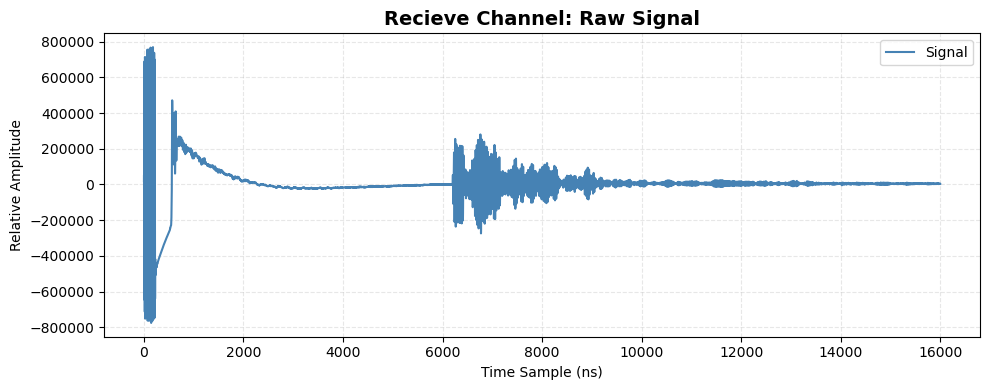

In [9]:
signal_plot(raw[0,1,:],start=0,end=16000,title="Recieve Channel: Raw Signal")

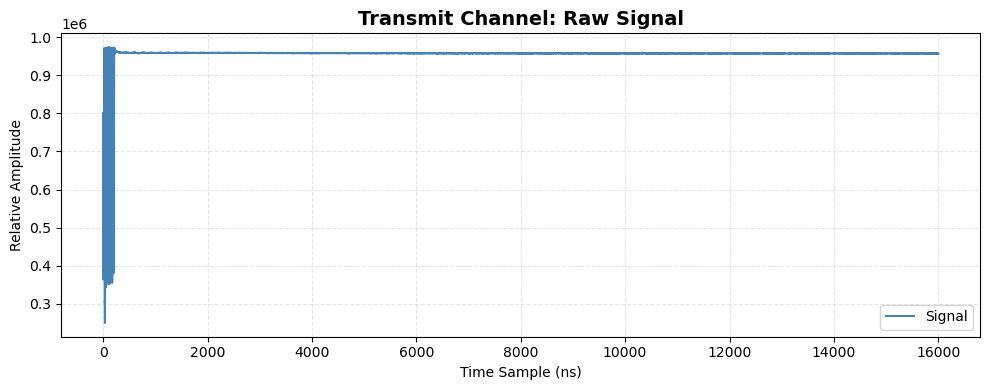

In [10]:
signal_plot(raw[0,0,:],start=0,end=16000,title="Transmit Channel: Raw Signal")

# Data Processing

#### DC offset removal

In [11]:
transmit, receive= dc_offset_removal(raw)

DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)


Text(0.5, 1.0, 'raw')

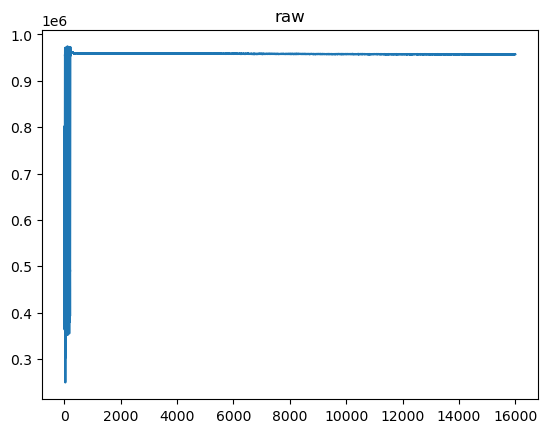

In [12]:
plt.plot(raw[0,0,:])
plt.title("raw")

Text(0.5, 1.0, 'DC offset')

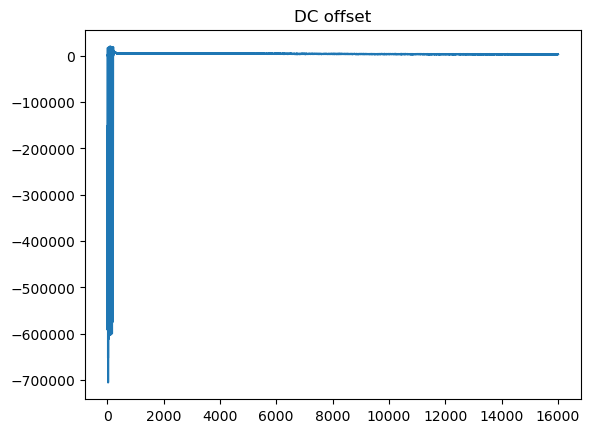

In [13]:
plt.plot(transmit[0])
plt.title("DC offset")

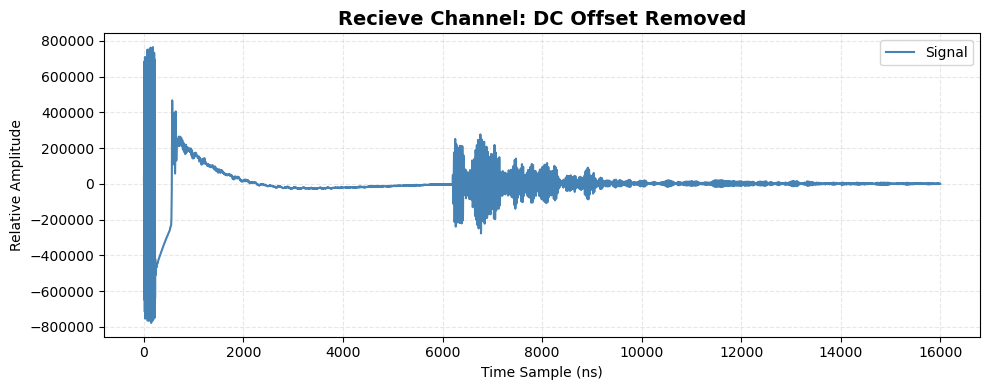

In [14]:
signal_plot(receive[0,:],start=0,end=16000,title="Recieve Channel: DC Offset Removed")

# Different Filtering Techniques in Time Domain

#### Time Synchronized Averaging (Experiments=100)

In [15]:
transmit.shape

(100, 16000)

In [16]:
transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(raw[:,0,:],receive,threshold=500000)

Transmit Valid signals after filtering: (33, 16000)
Recieve Valid signals after filtering: (33, 16000)


In [17]:
recieve_averaged_signal.shape

(1, 16000)

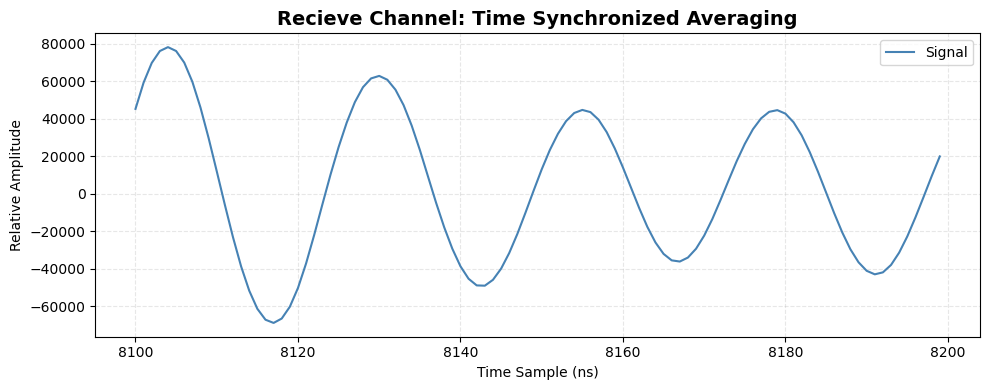

In [18]:
signal_plot(recieve_averaged_signal[0],start=8100,end=8200,title="Recieve Channel: Time Synchronized Averaging")

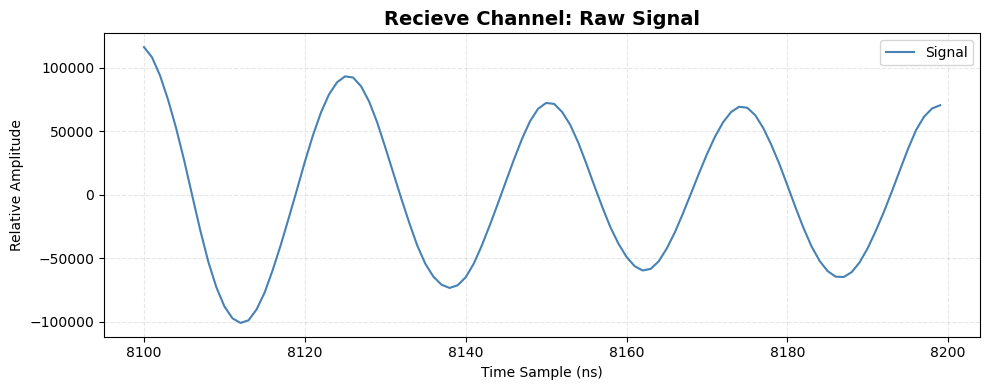

In [19]:
signal_plot(receive[0,:],start=8100,end=8200,title="Recieve Channel: Raw Signal")

#### Moving Average : Hanning filter or Triangular Filter

In [20]:
transmit_filtered_hanning = batch_apply_hanning_filter(transmit)
recieve_filtered_hanning = batch_apply_hanning_filter(receive)

In [21]:
# Print shape to verify
print("Hanning filter Transmit shape:", transmit_filtered_hanning.shape) 
print("Hanning filter Recieve shape:", recieve_filtered_hanning.shape) 

Hanning filter Transmit shape: (100, 16000)
Hanning filter Recieve shape: (100, 16000)


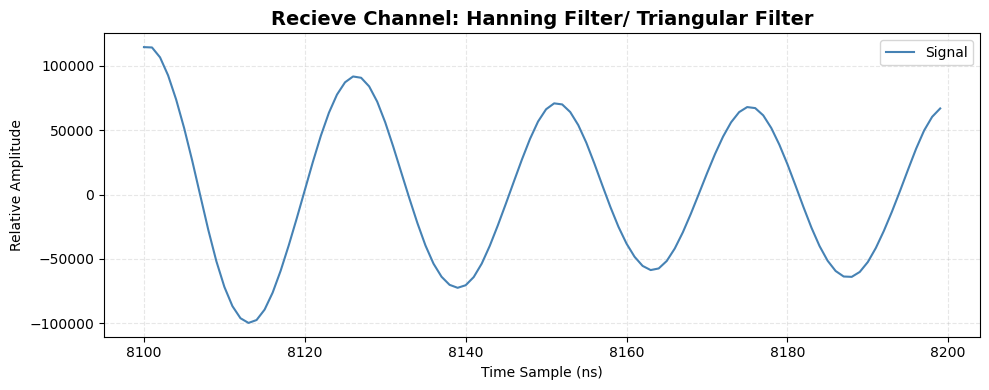

In [22]:
signal_plot(recieve_filtered_hanning[0],start=8100,end=8200,title="Recieve Channel: Hanning Filter/ Triangular Filter")

#### Uniform Moving Average

In [23]:
transmit_uniform_moving_avg=apply_uniform_moving_average_filter(transmit, window_size=11)
recieve_uniform_moving_avg=apply_uniform_moving_average_filter(receive, window_size=11)


In [24]:
recieve_uniform_moving_avg.shape

(100, 16000)

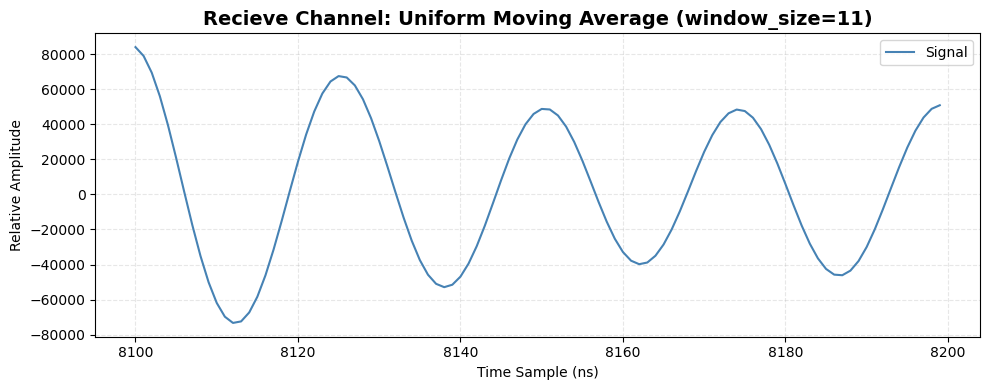

In [25]:
signal_plot(recieve_uniform_moving_avg[0],start=8100,end=8200,title="Recieve Channel: Uniform Moving Average (window_size=11)")

#### Derivative Filter

In [26]:
fs = 125e6  # Sampling frequency in Hz
T = 1 / fs  # Sampling period in seconds

In [27]:
transmit_filtered_derivative=apply_improved_derivative_filter(transmit, T=T)
receive_filtered_derivative=apply_improved_derivative_filter(receive, T=T)


In [28]:
receive_filtered_derivative.shape

(100, 16000)

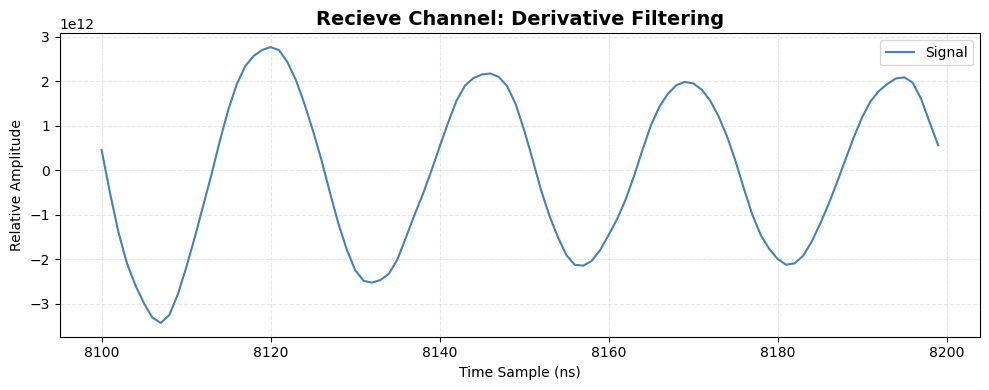

In [29]:
signal_plot(receive_filtered_derivative[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

### For smoothning of derivative filter, a uniform average filter is being applied

In [30]:
receive_filtered_derivative_smoothened=apply_uniform_moving_average_filter(receive_filtered_derivative, window_size=11)


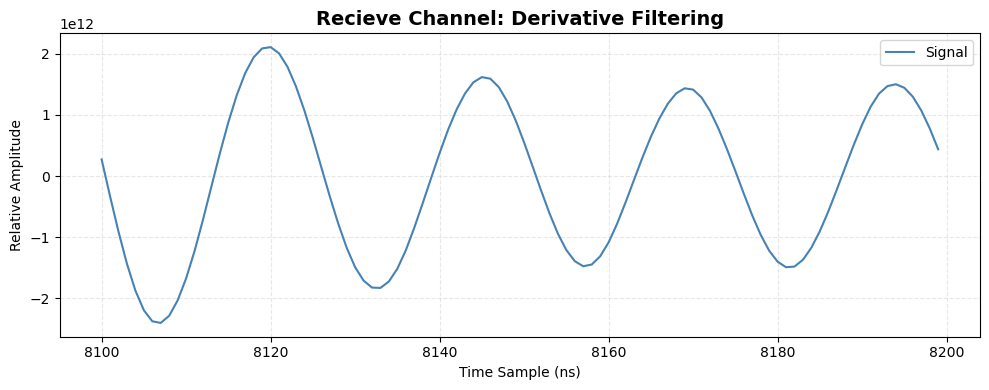

In [31]:
signal_plot(receive_filtered_derivative_smoothened[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

#### High Pass Filter

In [32]:

def highpass_filter(data, cutoff, fs, order=5):
    """
    Apply a high-pass Butterworth filter to a 2D signal array.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    # Design Butterworth high-pass filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    # Apply filter to each signal
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data


In [33]:
cutoff = 1_000_000  # 1 MHz
order = 1

recieve_highpass_filtered = highpass_filter(receive, cutoff, fs, order)


In [34]:
recieve_highpass_filtered.shape

(100, 16000)

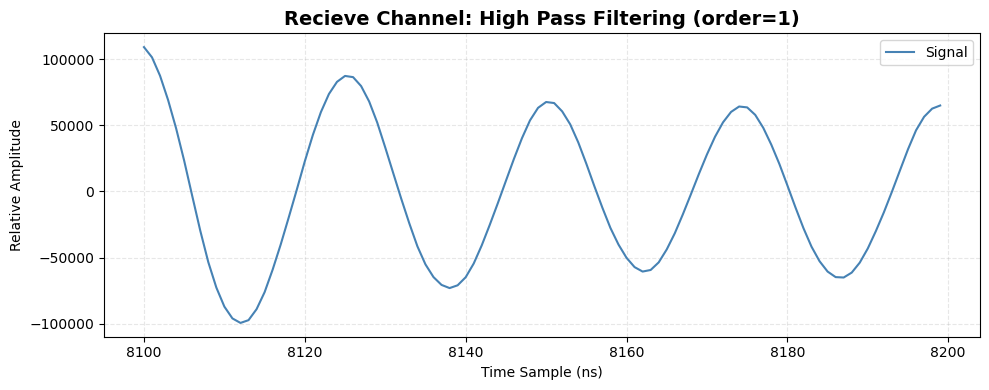

In [35]:
signal_plot(recieve_highpass_filtered[0,:],start=8100,end=8200,title="Recieve Channel: High Pass Filtering (order=1)")

### Bandpass Filter

In [36]:
start=0
end=16000

In [37]:
bandpassed_receive = apply_bandpass_filter(receive[0, start:end], fs, 1e6, 6.5e6)
#bandpassed_avg = apply_bandpass_filter(recieve_averaged_signal[0, start:end], fs, 4e6, 6e6)
bandpassed_hanning = apply_bandpass_filter(recieve_filtered_hanning[0, start:end], fs, 4e6, 6e6)


In [38]:
bandpassed_receive.shape

(16000,)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft(signal, fs, title=''):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, fft_vals)
    plt.title(f"FFT of {title}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xlim(0, fs / 2)
    plt.show()


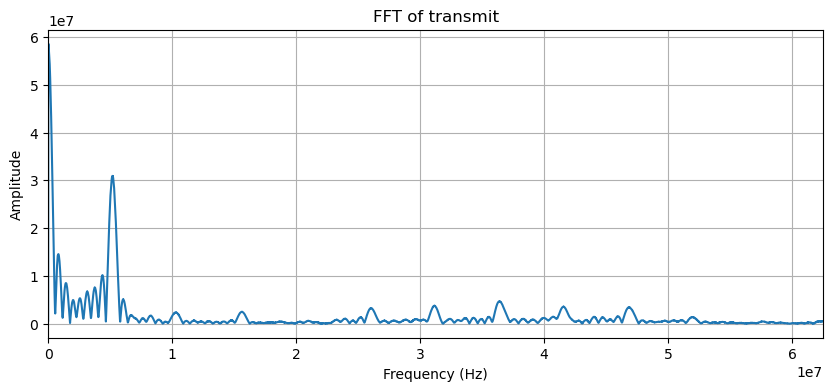

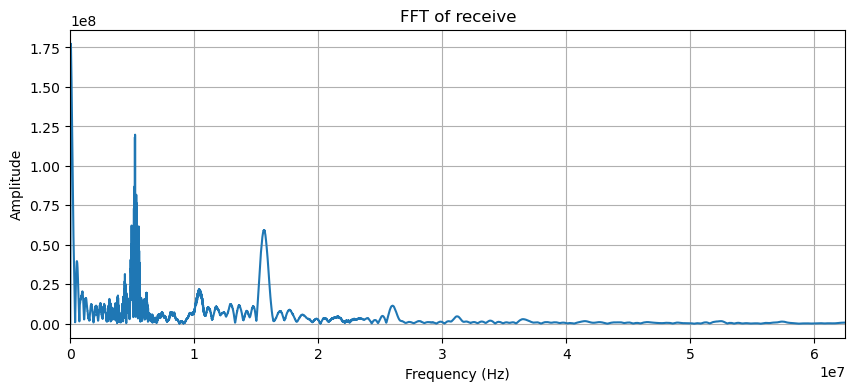

In [40]:
plot_fft(transmit[0,:], fs, title='transmit')

plot_fft(receive[0,:], fs, title='receive')


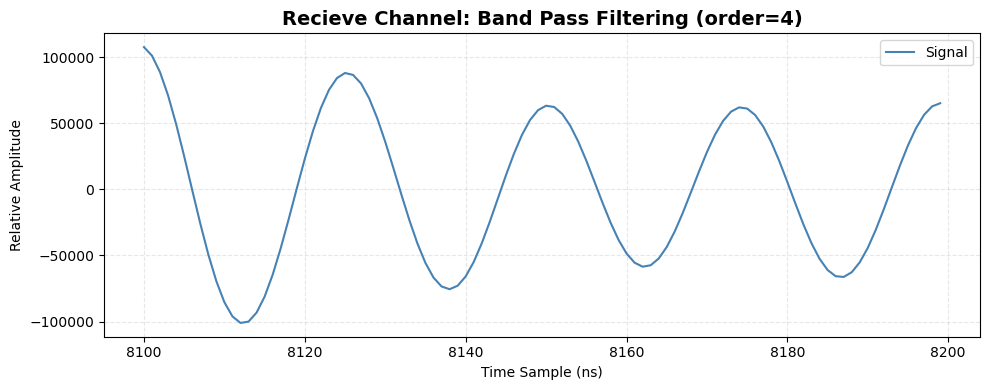

In [41]:

signal_plot(bandpassed_receive[:],start=8100,end=8200,title="Recieve Channel: Band Pass Filtering (order=4)")

#### Data Plotting (For Testing)

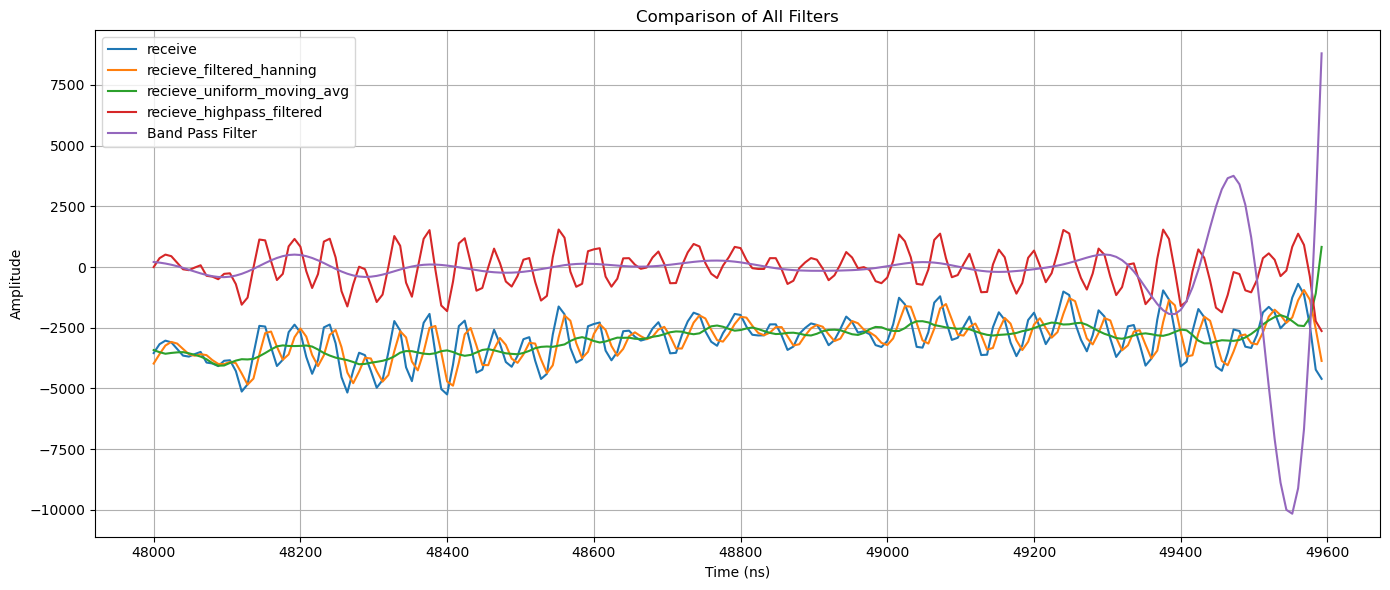

In [42]:
start=0
end=16000
Ts_ns = 1e9 / fs  # Sampling period in nanoseconds
time = np.arange(start, end) * Ts_ns

# Time setup again
zoom_local_start = 6000 - start
zoom_local_end = 6200 - start
zoom_time = time[zoom_local_start:zoom_local_end]

# Scale derivative for fair visual comparison
scaled_derivative = receive_filtered_derivative_smoothened[0, zoom_local_start:zoom_local_end] / 1e12  # Trillions to hundreds

plt.figure(figsize=(14, 6))

plt.plot(zoom_time, receive[0, zoom_local_start + start : zoom_local_end + start], label='receive')
#plt.plot(zoom_time, recieve_averaged_signal[0, zoom_local_start:zoom_local_end], label='recieve_averaged_signal')
plt.plot(zoom_time, recieve_filtered_hanning[0, zoom_local_start:zoom_local_end], label='recieve_filtered_hanning')
plt.plot(zoom_time, recieve_uniform_moving_avg[0, zoom_local_start:zoom_local_end], label='recieve_uniform_moving_avg')
plt.plot(zoom_time, recieve_highpass_filtered[0, zoom_local_start:zoom_local_end], label='recieve_highpass_filtered')
plt.plot(zoom_time, bandpassed_receive[zoom_local_start:zoom_local_end], label='Band Pass Filter')


plt.title("Comparison of All Filters")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Echo Detection

### Pan-Tompkins Inspired Pipeline / Pan–Tompkins algorithm


In [43]:
low_cutoff=1e6
high_cutoff=5e6
periods=9

In [44]:
receive.shape

bandpassed_receive = receive[0, start:end]
bandpassed_transmit = transmit[0, start:end]

In [45]:
transmit_echo_list,recieve_echo_list,transmit_min_max_pairs,recieve_min_max_pairs=apply_pan_algorithm(bandpassed_transmit,bandpassed_receive,periods,T,low_cutoff, high_cutoff, order=4, window_size=11,min_prominence=0.05)

Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(2, 212)]
Recieve [(6185, 9502)]


# Time of Flight Calculations

In [46]:
from time_of_flight_calculation.zero_crossings import *

In [47]:
transmit.shape

(100, 16000)

In [48]:
bandpassed_receive.shape

(16000,)

In [49]:
# Get the first transmit echo pair
transmit_max_pair = transmit_echo_list[0]

t_start_index = transmit_max_pair[0]
t_amplitude=transmit[0,t_start_index]

max_pair_transmit=(t_start_index,t_amplitude)


# Get the first recieve echo pair
recieve_max_pair = recieve_echo_list[0]

r_start_index = recieve_max_pair[0]
r_amplitude=bandpassed_receive[r_start_index]

max_pair_recieve=(r_start_index,r_amplitude)


#signal_detrended = detrend(transmit[0,:])



transmit_zero_pair = find_next_zero_crossings(transmit[0,:], [t_start_index])





extrema_indices:  [2]
Signal at index 2: -151988.1875 (sign: -1.0)
Signal slice after index 2: [-435590.2 -590615.2 -449417.2 -476408.2 -511678.2 -500953.2 -530021.2]
extrema_index: 2 type: <class 'int'>


In [50]:
transmit_zero_pair

[19.858153475278282]

In [51]:
#signal_detrended = detrend(receive[0,:])


In [52]:
receive_zero_pair = find_next_zero_crossings(receive[0,:], [r_start_index])
receive_zero_pair

extrema_indices:  [6185]
Signal at index 2: -133711.8125 (sign: -1.0)
Signal slice after index 2: [ -82218.82 -196973.81 -538068.8  -648030.8  -543318.8  -457222.8
 -486016.8 ]
extrema_index: 6185 type: <class 'int'>


[6201.504097174629]

In [53]:
from time_of_flight_calculation.tof import *
from time_of_flight_calculation.velocity import *
from time_of_flight_calculation.sugar_velocity_relationship import *

In [54]:
tof = findTOF(transmit_zero_pair, receive_zero_pair) #peak to peak tof


Time of Flight Indices: 19.858153475278282 6201.504097174629
Time of flight in seconds: 4.945316754959481e-05


In [55]:
converted_velocity,time_of_flight,actual_waveform,receive_selected_index_list,transmit_selected_index_list =process_signals(unique_file_list)



 File Name: /Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ9-pure_water_solution_1.mat
shape of raw signal:  (100, 2, 16000)
Period:  9
Concentration:  144000
DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)
Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(2, 212)]
Recieve [(6116, 9003)]
extrema_indices:  [2]
Signal at index 2: -151882.375 (sign: -1.0)
Signal slice after index 2: [-422851.38 -589249.4  -436561.38 -462397.38 -508961.38 -507515.38
 -518739.38]
extrema_index: 2 type: <class 'int'>
extrema_indices:  [6116]
Signal at index 2: -136644.515625 (sign: -1.0)
Signal slice after index 2: [ -85978.516 -191463.52  -531795.5   -646313.5   -542655.5   -459860.5
 -505311.5  ]
extrema_index: 6116 type: <class 'int'>
Time o

In [56]:
velocities=converted_velocity

In [57]:
velocities = sorted(velocities, key=lambda x : x[0])
velocities

[[0.0, 1674.456235627779],
 [1.0588235294117647, 1675.772115585907],
 [2.1176470588235294, 1678.3555859543733],
 [3.1764705882352944, 1680.9212430763337],
 [4.235294117647059, 1684.4023588015289],
 [5.294117647058823, 1687.0451406517484],
 [6.352941176470589, 1692.4605591323102],
 [7.411764705882354, 1695.3138231069395],
 [8.470588235294118, 1697.6932307719042]]

In [58]:
def plot_velocity_refractometer(velocities, actual_waveform):
    """
    Plots Velocity vs Concentration with a very faint dotted line for Refractometer vs. Concentration.
    
    velocities: List of tuples with (concentration, velocity)
    actual_waveform: String representing the waveform type.
    """
    waveform=actual_waveform[0:3]
    if waveform=='sin':
        waveform='Sinusoidal'
    else:
        waveform='Square'
    
    burst_size=actual_waveform[-1]

    #velocities = sorted(velocities, key=lambda x: float(x[0].rstrip('%')))
    velocities = sorted(velocities, key=lambda x: x[0])


    concentrations = [item[0] for item in velocities]
    velocity_values = [item[1] for item in velocities]

    # Refractometer values should be a direct mapping (0% -> 0, 1% -> 1, ..., 10% -> 10)
    refractometer_values = [conc for conc in concentrations]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Concentration (%)')
    ax1.set_ylabel('Velocity (m/s)', color='tab:blue')
    ax1.plot(concentrations, velocity_values, marker='o', linestyle='-', color='tab:blue', label='Velocity')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    # ax1.set_ylim([min(velocity_values)-1.4,max(velocity_values)+2])

    ax2 = ax1.twinx()
    ax2.set_ylabel('Refractometer Reading', color='tab:red')  # Faint axis label
    ax2.plot(concentrations, refractometer_values, marker='s', linestyle=':', color='tab:red', alpha = 0.3)  
    ax2.tick_params(axis='y', labelcolor='tab:red')  # Keeping it standard without 'alpha'

    plt.title(f'Velocity vs Sugar Concentration of ({waveform}) waveform with Burst Size {burst_size}', fontsize = 12, fontweight='normal')
    ax1.grid(True)

    # Show Plot
    plt.show()

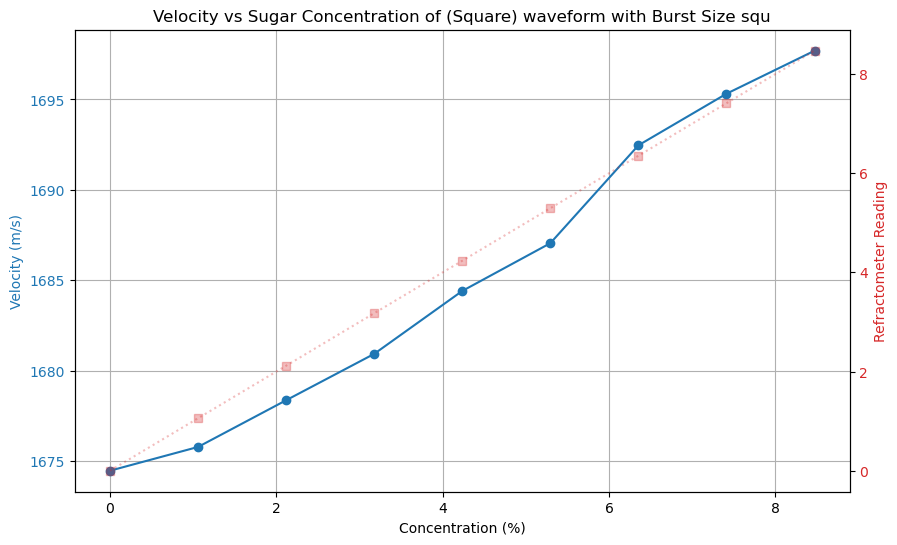

In [59]:
plot_velocity_refractometer(velocities[::1], waveforms)